## Introduction to the automated analysis of EEG quality

This notebook will introduce you to the challenge by going through the data and working towards a first very simple model.

## Loading the data

In [ ]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd

ROOT_PATH = Path("/kaggle/input/eeg-signal-quality-analysis-by-beacon-biosignals/train/")
training_data = [(np.load(ROOT_PATH / f"data_{i}.npy"),np.load(ROOT_PATH / f"target_{i}.npy")) for i in range(4)]


We expect to have five channels and one label per channel for each two seconds of data.
Let's have a look at the data duration and shape

In [ ]:
# Let's have a look at the data duration
for i,(data,target) in enumerate(training_data):
    print()
    print(f"Recording {i}")
    print("Data shape", data.shape,target.shape)
    print("Data duration:", data.shape[1]/250)
    print("Labels duration",target.shape[1] * 2)
    



Recording 0
Data shape (5, 7712740) (5, 15425)
Data duration: 30850.96
Labels duration 30850

Recording 1
Data shape (5, 5232364) (5, 10464)
Data duration: 20929.456
Labels duration 20928

Recording 2
Data shape (5, 6421756) (5, 12843)
Data duration: 25687.024
Labels duration 25686

Recording 3
Data shape (5, 6809761) (5, 13619)
Data duration: 27239.044
Labels duration 27238


## Plotting the EEG and labels

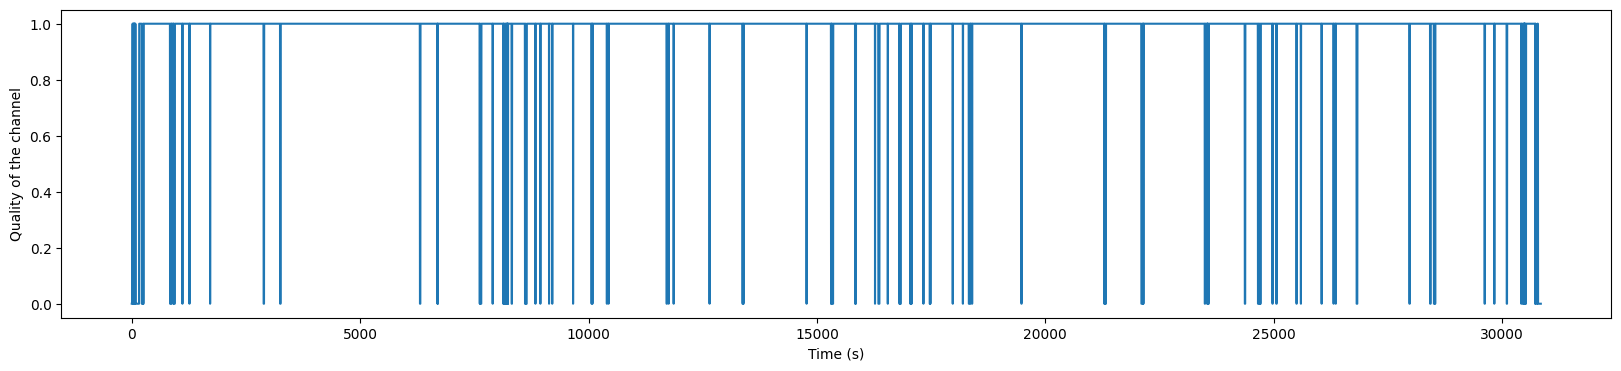

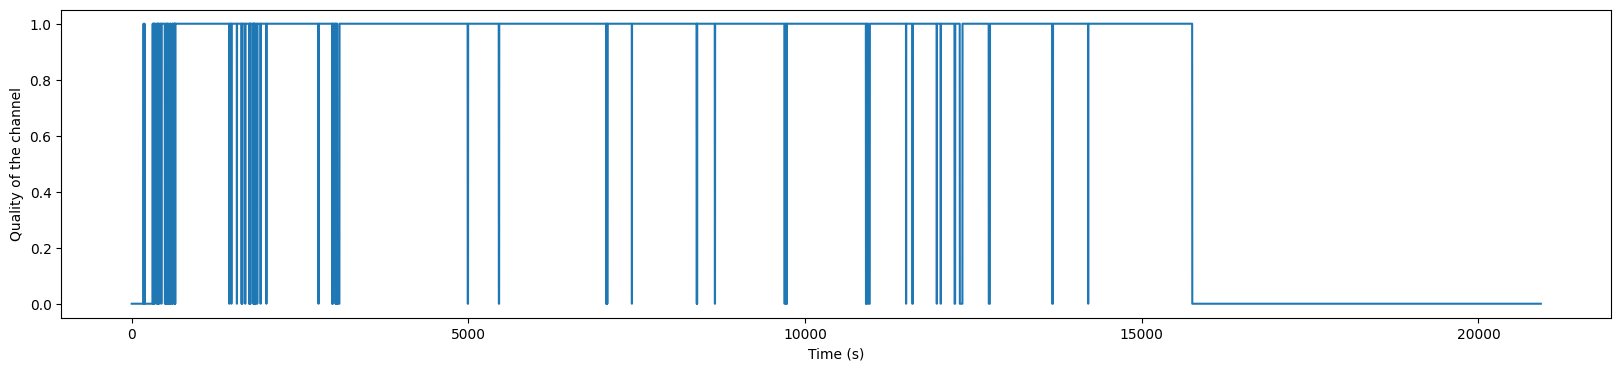

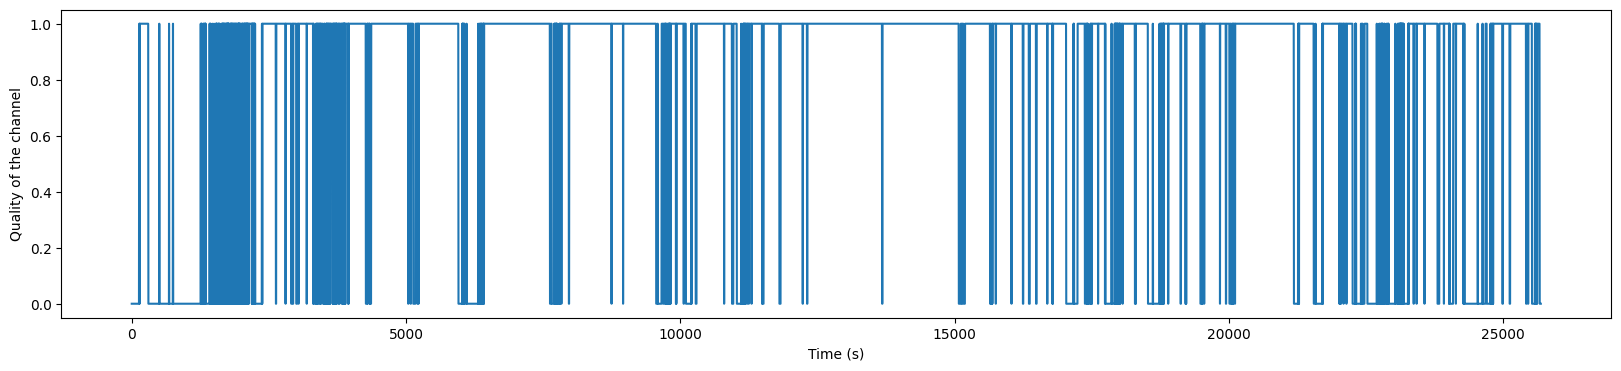

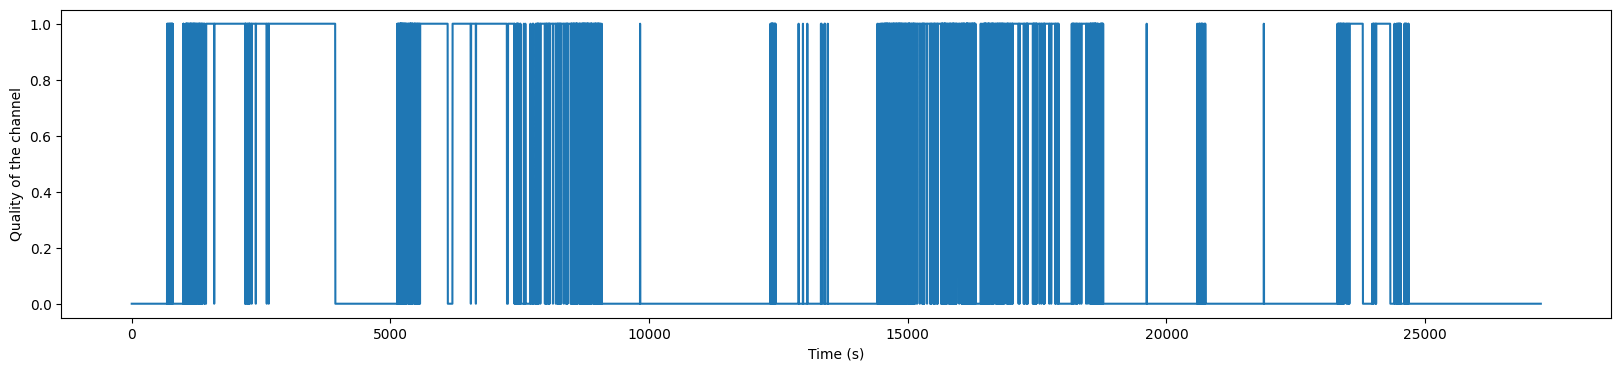

In [ ]:

# Let's plot the target from the first channel for all the recordings
for i,(data,target) in enumerate(training_data):
    plt.figure(figsize=(20,4))
    plt.plot(np.arange(0,len(target[0])) * 2, target[0])
    plt.ylabel('Quality of the channel')
    plt.xlabel("Time (s)")
    plt.show()

In [ ]:
## We improve a bit the plotting code to plot span of data and corresponding label

def plot_predictions_and_signal(
    target,
    data,
    start_time: float,
    stop_time: float,
    data_sampling_rate: int = 250,
    target_duration: int = 2,
    channel_to_plot: int = 0,
):
    """
    
    
    """

    # Calculate the start and stop indices for the signal
    start_idx_signal = int(start_time * data_sampling_rate)
    stop_idx_signal = int(stop_time * data_sampling_rate)

    # Calculate the start and stop indices for the labels
    start_idx_label = int(start_time / target_duration)
    stop_idx_label = int(stop_time / target_duration)

    # Slice the data and prediction probabilities
    sliced_signal = data[channel_to_plot, start_idx_signal:stop_idx_signal]
    sliced_prediction_prob = (
        target[channel_to_plot, start_idx_label:stop_idx_label]
    )

    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    # Plot the sliced EEG signal
    ax[0].plot(np.arange(len(sliced_signal)) / data_sampling_rate, sliced_signal)
    ax[0].set_title("EEG signal")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(
        np.arange(len(sliced_prediction_prob)) * target_duration,
        sliced_prediction_prob,
    )
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Probs")

    plt.show()



0.5086964831804281


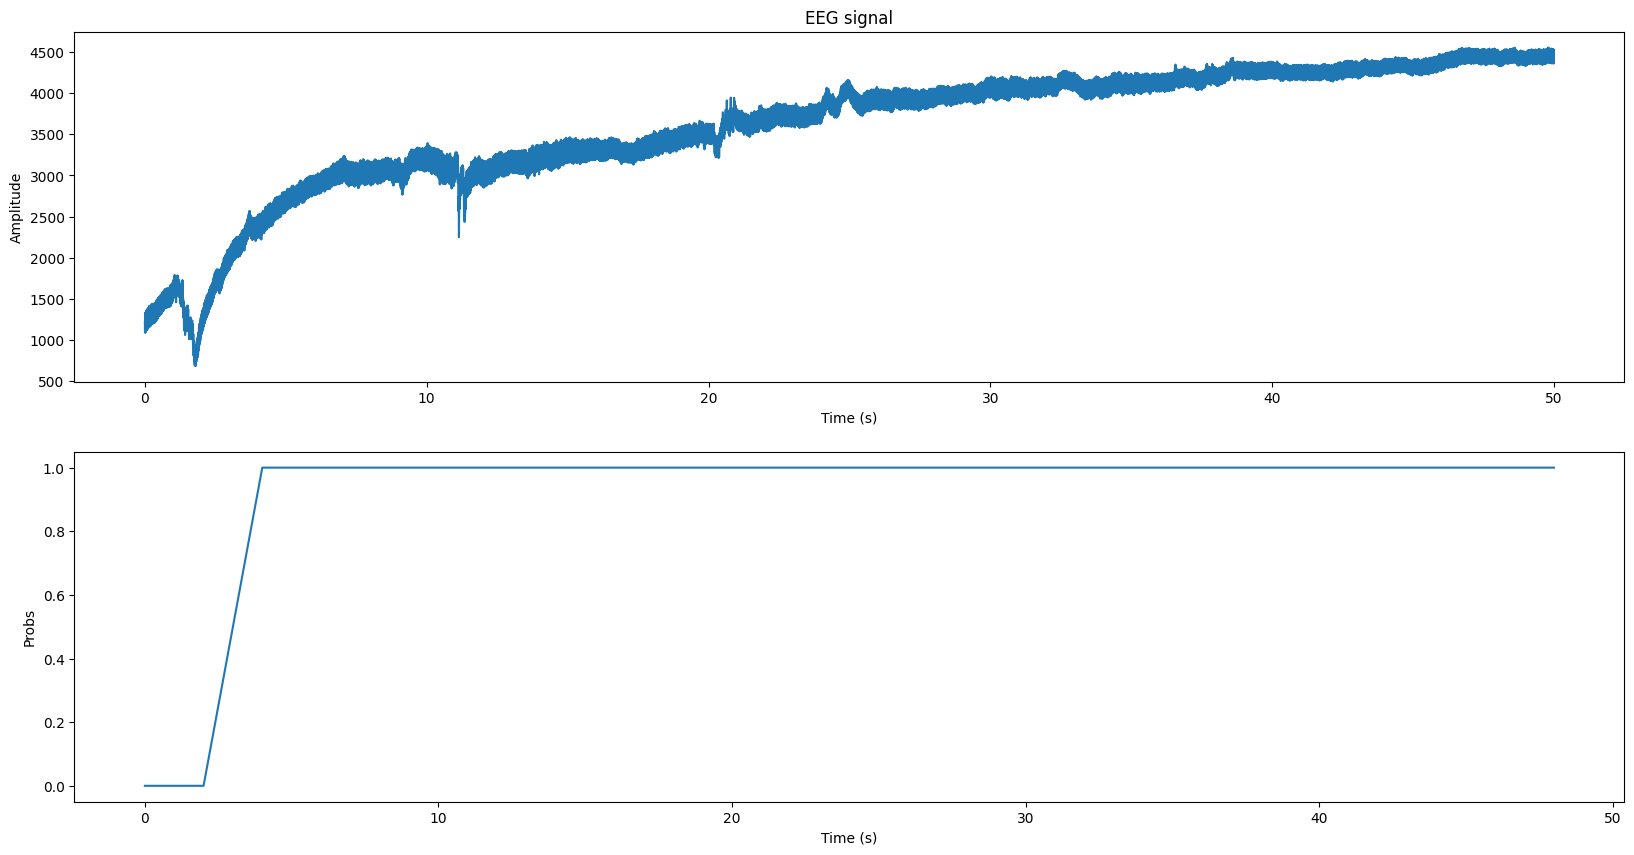

In [ ]:
# We first plot the data and target from the first recording
# We see that there is a big DC component 
target = np.load("/kaggle/input/eeg-signal-quality-analysis-by-beacon-biosignals/train/target_1.npy")
data = np.load("/kaggle/input/eeg-signal-quality-analysis-by-beacon-biosignals/train/data_1.npy")
print(np.mean(target))
plot_predictions_and_signal(target,data,start_time = 300, stop_time = 350, data_sampling_rate = 250,target_duration = 2, channel_to_plot = 2)

To remove the DC component and high frequency component we apply a band-pass filter

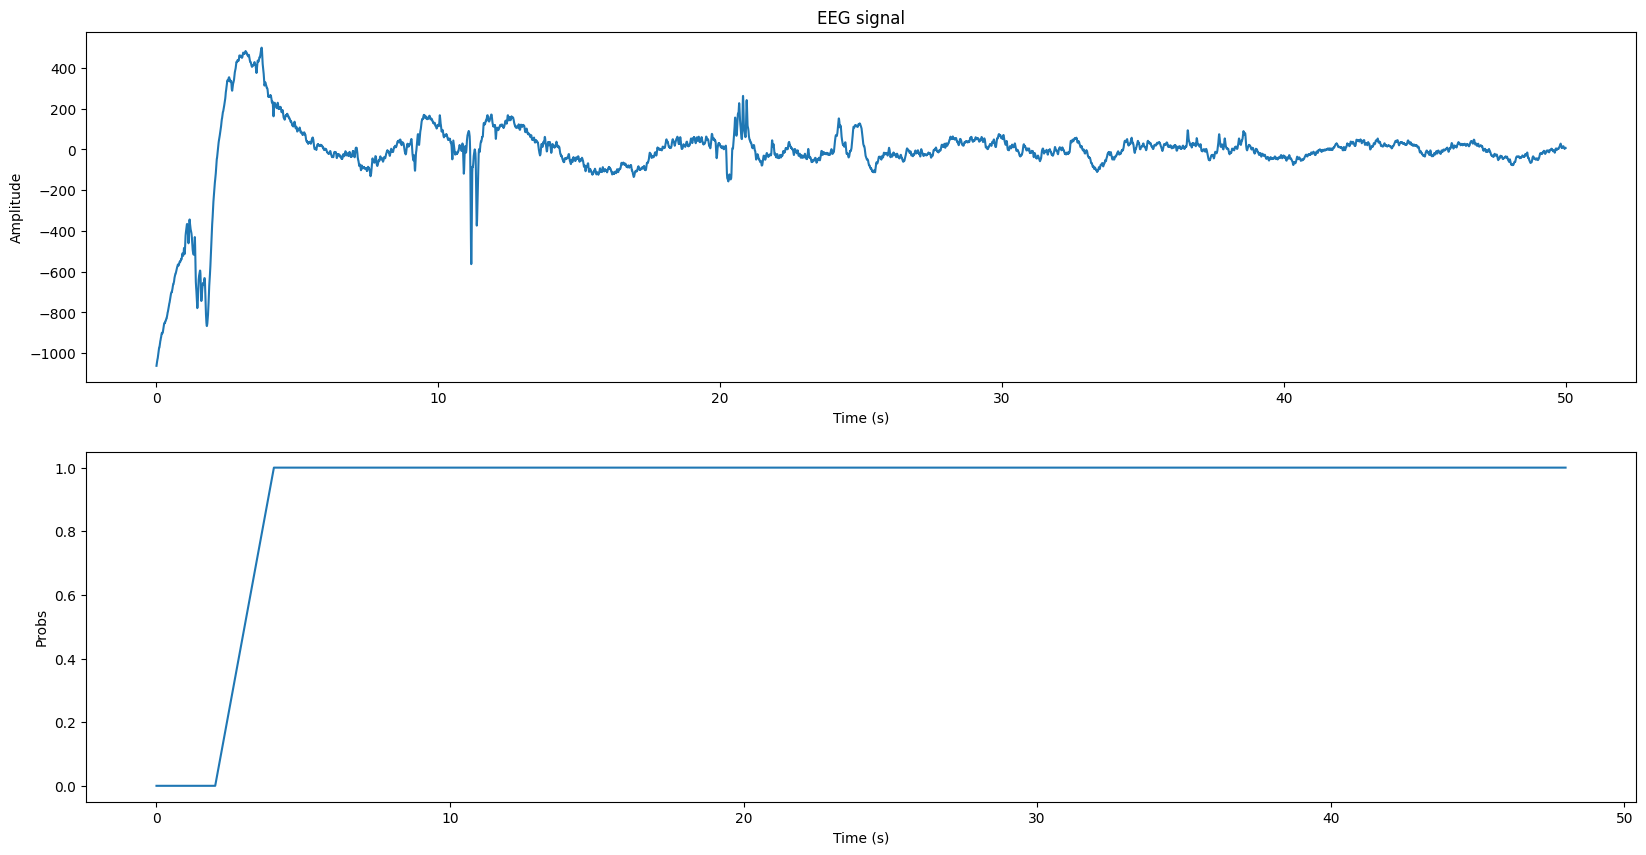

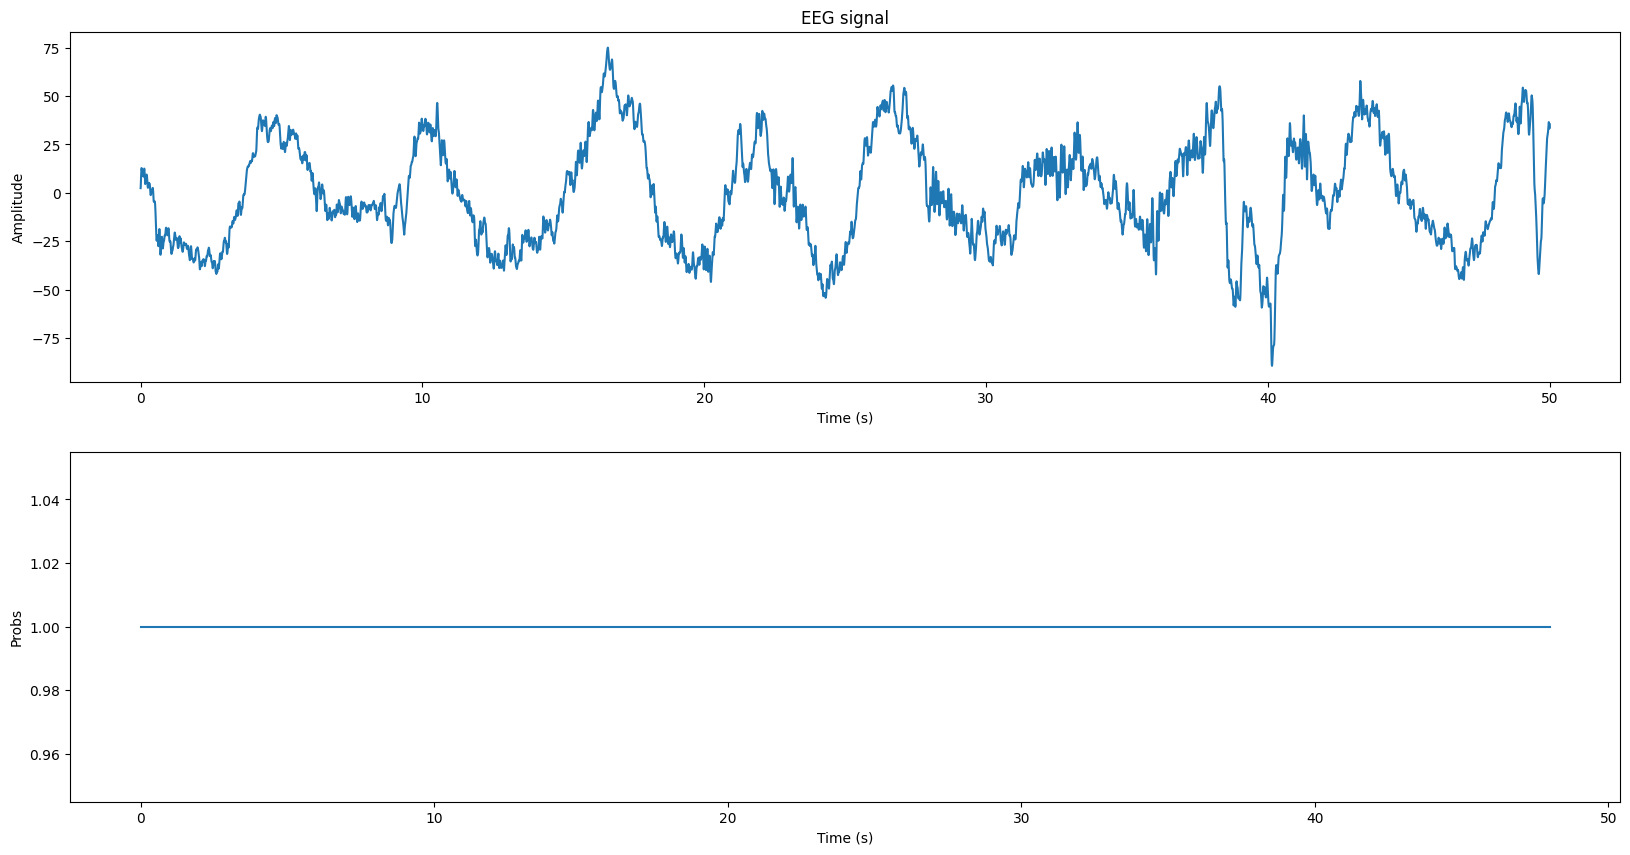

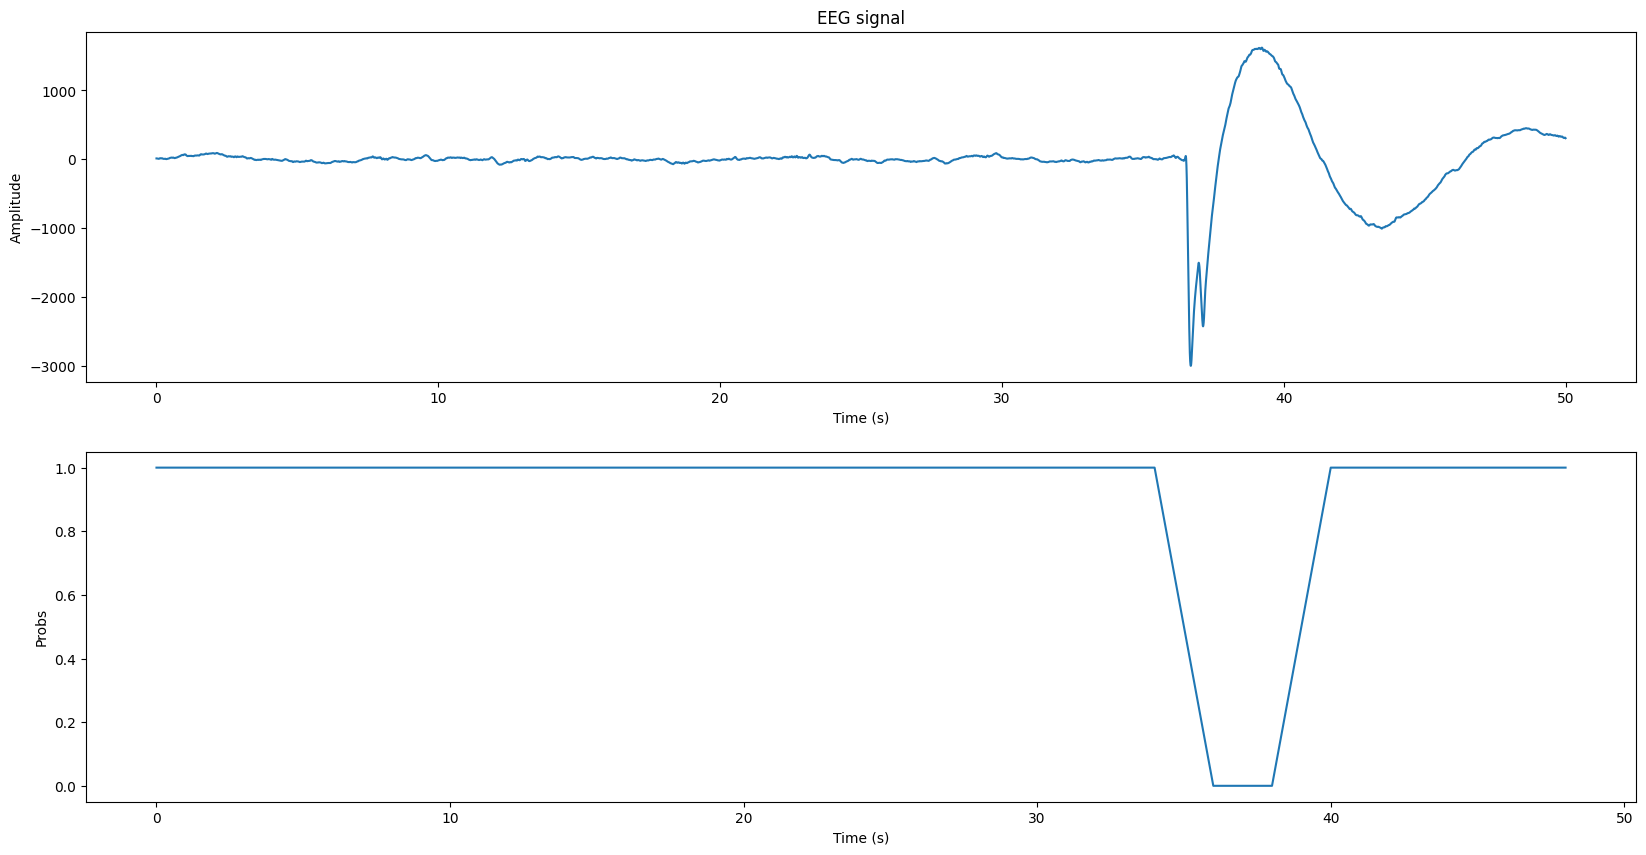

In [ ]:
# Let's filter the signal to improve the visualisation

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

filtered_data = butter_bandpass_filter(data,0.1,18,250,4)
# We plot three spans and associated labels from the recording

plot_predictions_and_signal(target,filtered_data,start_time = 300, stop_time = 350, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)
plot_predictions_and_signal(target,filtered_data,start_time = 1000, stop_time = 1050, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)
plot_predictions_and_signal(target,filtered_data,start_time = 3000, stop_time = 3050, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)

We see that some of the high amplitude is classified as bad quality, we could use that to build a first simple model

## Exploring the statistics of the good and bad quality EEG

In [ ]:
# First we need to get the point that maps to a label

def reshape_array_into_windows(x, sample_rate, window_duration_in_seconds):
    """
    Reshape the data into an array of shape (C, T, window) where 'window' contains
    the points corresponding to 'window_duration' seconds of data.

    Parameters:
    x (numpy array): The input data array.
    sample_rate (int): The number of samples per second.
    window_duration_in_seconds (float): The duration of each window in seconds.

    Returns:
    reshaped_x (numpy array): The reshaped array with shape (C, T, window).
    """
    # Calculate the number of samples in one window
    window_size = int(window_duration_in_seconds * sample_rate)
    
    # Ensure the total length of x is a multiple of window_size
    total_samples = x.shape[-1]
    if total_samples % window_size != 0:
        # Truncate or pad x to make it divisible by window_size
        x = x[..., :total_samples - (total_samples % window_size)]
    # Reshape x into (C, T, window)
    reshaped_x = x.reshape(x.shape[0], -1, window_size)

    return reshaped_x


In [ ]:
reshaped_array = reshape_array_into_windows(filtered_data,250,2)
# Quick unit test to ensure the reshape worked as expected
assert np.array_equal(reshaped_array[0,0],filtered_data[0,:500])
assert np.array_equal(reshaped_array[0,1],filtered_data[0,500:1000])
assert np.array_equal(reshaped_array[0,10],filtered_data[0,5000:5500])
assert np.array_equal(reshaped_array[1,1],filtered_data[1,500:1000])




In [ ]:
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude = (np.max(reshaped_array,-1) - np.min(reshaped_array,-1)).reshape(-1)
targets_flatten = target[..., :len(reshaped_array[0])].reshape(-1)

In [ ]:
data = pd.DataFrame({"amplitude":amplitude,"target":targets_flatten})

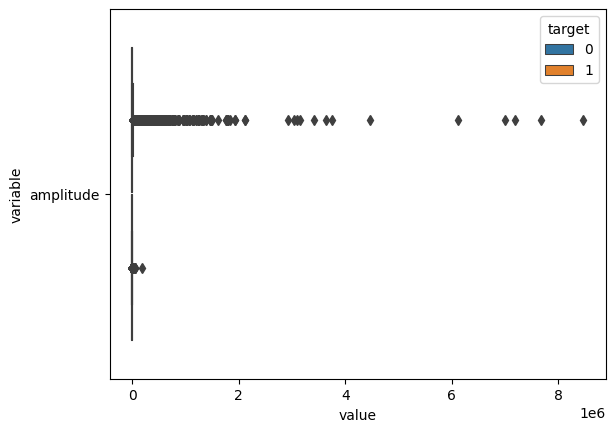

In [ ]:
melted_data = pd.melt(data, value_vars = ["amplitude"],id_vars = "target")
sns.boxplot(melted_data,y = "variable", x = "value",hue = "target")
plt.show()

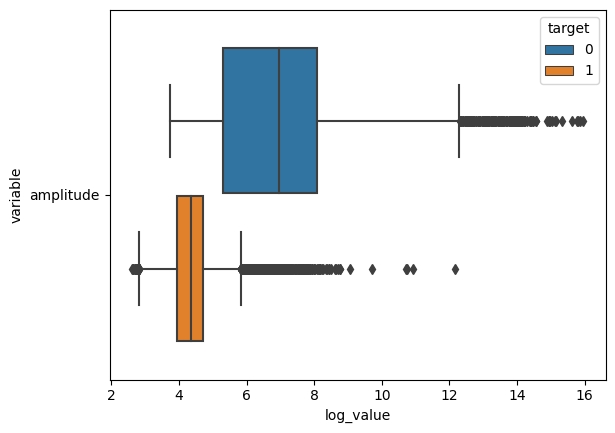

In [ ]:
# We need to take the log to visualize the data better
# The goof (target = 1) and bad (target = 0) data seems to be relatively separable based on our three features
melted_data["log_value"] = np.abs(np.log(melted_data.value + 1))
sns.boxplot(melted_data,y = "variable", x = "log_value",hue = "target")
plt.show()

## Building a simple model based on our observation

In [ ]:
# We first load and reshape all the data
all_data = []
all_targets = []
for (data,target) in training_data:
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_array_into_windows(filtered_data,250,2)
    targets_flatten = target[..., :len(reshaped_data[0])].reshape(-1)
    reshaped_data = reshaped_data.reshape((-1,reshaped_data.shape[-1]))
    all_data.append(reshaped_data)
    all_targets.append(targets_flatten)
all_data = np.concatenate(all_data)
all_targets = np.concatenate(all_targets)
assert all_data.shape[0] == all_targets.shape[0]


In [ ]:
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude = (np.max(all_data,-1) - np.min(all_data,-1)).reshape(-1)
training_data = pd.DataFrame({"amplitude":amplitude,"target":all_targets})

In [ ]:
# We train a model on 70% of the data and evaluate the model on the remaining 30%
prop_train = 0.7
n_train = int(prop_train * len(training_data))
train_set = training_data[:n_train]
val_set = training_data[n_train:]
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=8)
neigh.fit(np.array(train_set[["amplitude"]]), train_set["target"])
prediction = neigh.predict(np.array(val_set[["amplitude"]]))

We can now evaluate the cohen kappa

In [ ]:
from sklearn.metrics import cohen_kappa_score, f1_score
print(cohen_kappa_score(prediction,val_set["target"]))
print(f1_score(val_set["target"],prediction))

0.44244718359147084
0.6559124745520382


- What do you think of the performances ?
- What do you think of the split strategy ?
- What are additional features you could use ?

## Running the model on the test data and submitting to the leaderboard


In [ ]:
ROOT_TEST_PATH = Path("/kaggle/input/eeg-signal-quality-analysis-by-beacon-biosignals/test/")
test_data = {i:np.load(ROOT_TEST_PATH / f"data_{i}.npy") for i in [4,5]}
# We process each record independantly

def compute_features_on_record(data):
    """
    We compute each of the feature for each window and each channel
    Each value of the output dict has shape (Channels,T)
    """
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_array_into_windows(filtered_data,250,2)
    amplitude = (np.max(reshaped_data,-1) - np.min(reshaped_data,-1))
    return {"amplitude":amplitude}

def compute_predictions_on_record(data,model,features_name_for_model):
    predictions = []
    features = compute_features_on_record(data)
    features = np.array([features[k] for k in features_name_for_model]) 
    features = features.swapaxes(0,1).swapaxes(1,2)
    for channel in range(features.shape[0]):
        predictions.append(model.predict(features[channel]))
    return np.array(predictions)

def format_array_to_target_format(array, record_number):
    assert isinstance(record_number, int)
    assert isinstance(array, np.ndarray)
    assert len(array.shape) == 2
    assert array.shape[0] == 5
    assert set(np.unique(array)) == {0, 1}
    formatted_target = []
    for i in range(array.shape[0]):
        channel_encoding = (i + 1) * 100000
        record_number_encoding = record_number * 1000000
        for j in range(array.shape[1]):
            formatted_target.append(
                {
                    "identifier": record_number_encoding + channel_encoding + j,
                    "target": array[i, j],
                }
            )
    return formatted_target
    


We the functions defined above, we can now run the model and submit the predictions

In [ ]:
results = []
for record_number, data in test_data.items():
    preds = compute_predictions_on_record(data,neigh,["amplitude"])
    formatted_preds = format_array_to_target_format(preds,record_number)
    results.extend(formatted_preds)
df = pd.DataFrame(results)
df.to_csv("submission.csv",index = False)